# Exercise 5: Overlap-Save and Partitioned Filtering

In this exercise we will regard the convolution of a signal with a given impulse response. The filter
will be applied in the frequency domain using the Overlap-Save method. Additionally, we will pay
special attention to delays caused by long impulse responses. Therefore the impulse response will be
segmented into blocks and the convolution will be processed in a parallel procedure. This partioned
block-wise processing in the frequency domain is called a Partitioned Block Frequency-Domain
Filter (PBFD).

#### Imports and Helper Functions

In [1]:
import numpy as np
import wave
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import Audio, display
from numpy.fft import fft, ifft

In [2]:
def plot_signal(x, sample_rate, *args, **kwargs):
    t = np.r_[:len(x)]*1/sample_rate
    plt.plot(t, x)
    plt.axhline(c='k', alpha=0.75)
    plt.axvline(c='k', alpha=0.75)
    plt.xlabel(kwargs.get('x_label', r'$t / \mathrm{s}$'), fontsize=14)
    plt.ylabel(kwargs.get('y_label', r'$x(t)$'), fontsize=14)
    plt.grid(True)

In [3]:
def show_signal(x, sample_rate, *args, **kwargs):
    display(Audio(x, rate=sample_rate))
    plot_signal(x, sample_rate, *args, **kwargs)

In [4]:
def normalize(x):
    return x / np.abs(x).max()

## Task 5.1 :
How large is the delay of a frequency domain filter approach?

## Read in a speech signal and an impulse response

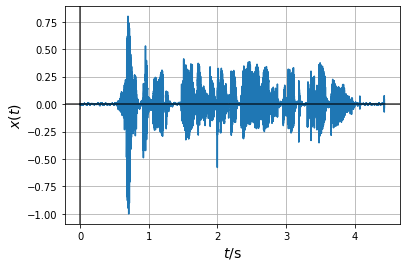

In [5]:
sample_rate, in_signal = read('fg_nt_upb_16k.wav')
in_signal = normalize(in_signal.astype(np.float))
show_signal(in_signal, sample_rate)

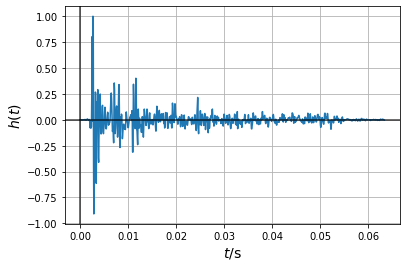

In [6]:
sample_rate_rir, rir = read('raumimpulsantwort.wav')
assert np.isclose(sample_rate_rir, sample_rate), \
    "The sample rates do not match!"
rir = normalize(rir.astype(np.float))
show_signal(rir, sample_rate, y_label=r'$h(t)$')

## Task 5.2

Complete the function `filter_overlap_save`:
1. Perform the convolution in the time domain and measure the processing time.
2. Perform the convolution in the frequency domain using the Overlap-Save method and measure
the processing time.
3. Compare and save both output signals

In [7]:
%timeit normalize(np.convolve(rir, in_signal))

10.5 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


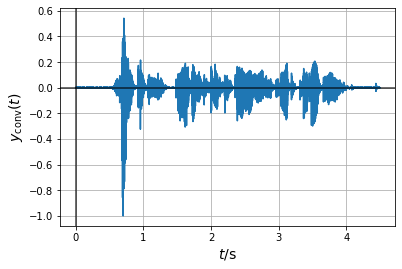

In [8]:
out_conv = normalize(np.convolve(rir, in_signal))
show_signal(out_conv, sample_rate, y_label=r'$y_\mathrm{conv}(t)$')

In [ ]:
def filter_overlap_save(in_signal, impulse_response, fft_length=2048):
    shift = fft_length - len(rir) + 1    # block length B in formulas
    num_blocks = len(in_signal) // shift

    rir_ft = fft(rir, fft_length)
    input_block = np.zeros(fft_length)
    out_signal = np.zeros(num_blocks * shift)

    for m in range(num_blocks):
        # TODO
    return out_signal

In [ ]:
%timeit normalize(filter_overlap_save(in_signal, rir))

In [ ]:
out_overlap_save = normalize(filter_overlap_save(in_signal, rir))
show_signal(out_overlap_save, sample_rate, y_label=r'$y_{\mathrm{OA}}(t)$')

In [ ]:
error_signal = out_overlap_save - out_conv[:len(out_overlap_save)]
plot_signal(error_signal, sample_rate, y_label=r'$e(t)$')
print('Power of error signal: {:0.3e}'.format(np.abs(error_signal**2).mean()))

## Task 5.3
Explain the partitioned block frequency-domain filter approach in detail!

## Task 5.4:
How large is the delay if a PBFD filter is used?

### Solution:
- The implementation is a bit more complicated and thus easier to mess up.
- The additional shift and memory load operations add an overhead to the processing time and thus the FFT length might need to be readjusted.
- The memory footprint of the algorithm is enlarged because more buffers are needed


## Load a Long Room Impulse Response

In [ ]:
sample_rate_rir_long, rir_long = read('IR_cathedral_16k.wav')
assert np.isclose(sample_rate, sample_rate_rir_long), \
    "The sample rates do not match!"
rir_long = normalize(rir_long.astype(np.float))
show_signal(rir_long, sample_rate, y_label=r'$h_\mathrm{cathedral}(t)$')

## Task 5.6:

Complete the function `partitioned_block_overlap_save`:
1. Extend the previous algorithm to accumulate over all partitions.
2. Perform the convolution also in the time domain to compare the results and processing times.

In [ ]:
def partitioned_block_overlap_save(in_signal, impulse_response, fft_length=512):
    
    shift = fft_length // 2
    num_blocks = len(in_signal) // shift
    partitions = len(impulse_response) // shift + 1
    ir_length = partitions * shift
    
    # pad with zeros, thus length is multiple of partitions
    impulse_response = np.r_[
        impulse_response, np.zeros(ir_length - len(impulse_response))]
    # break into partitions and do fft on each
    impulse_response_ft = fft(impulse_response.reshape((partitions, -1)), fft_length)
    
    assert impulse_response_ft.shape == (partitions, fft_length), \
        "Malformed impulse response array after fourier transformation!"

    out_signal = np.zeros(num_blocks*shift)
    input_block = np.zeros(fft_length)
    fft_buffer = np.zeros((partitions, fft_length), dtype=np.complex128)

    for m in range(num_blocks):
        # TODO

    return out_signal

#### Timing of Convolution

In [ ]:
%timeit normalize(np.convolve(rir_long, in_signal))

In [ ]:
out_conv_long = normalize(np.convolve(rir_long, in_signal))
show_signal(out_conv_long, sample_rate, y_label=r'$y_\mathrm{conv,long}(t)$')

In [ ]:
%timeit normalize(partitioned_block_overlap_save(in_signal, rir_long))

In [ ]:
out_pbos = normalize(partitioned_block_overlap_save(in_signal, rir_long))
show_signal(out_pbos, sample_rate, y_label=r'$y_\mathrm{pbos,long}(t)$')

In [ ]:
error_long = out_pbos - out_conv_long[:len(out_pbos)]
plot_signal(error_long, sample_rate, y_label=r'$e_\mathrm{long}(t)$')
print("Power of long error signal: {}".format(np.abs(error_long**2).mean()))